In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import statsmodels.api as sm
import math

In [185]:
# Read in the data and convert datetimes
dat = pd.read_csv('driver_model_dataset_v1 (1).csv')

dat['first_completed_trip_timestamp'] = pd.to_datetime(dat['first_completed_trip_timestamp'])
dat['signup_timestamp'] = pd.to_datetime(dat['signup_timestamp'])
dat['bgc_date'] = pd.to_datetime(dat['bgc_date'])
dat['vehicle_added_date'] = pd.to_datetime(dat['vehicle_added_date'])

In [186]:
dat.head()

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp
0,082befb0-c1de-4c14-8700-94a7943a7545,Strark,NaN,R2D,2017-07-06 20:42:17,NaT,2017-07-06 20:42:56,Volkswagen,CC,2012,NaT
1,1ae6156f-63fc-40cf-9734-0995978c4b6e,Berton,ios web,Dost,2017-07-03 17:41:07,2017-07-03 17:42:06,2017-07-03 17:41:14,Toyota,4Runner,2003,2017-07-23 00:26:50
2,2a4a4eef-14ef-4ceb-82eb-66f1f7d0d219,Berton,NaN,R2D,2017-07-10 22:55:29,NaT,2017-07-11 17:44:44,Hyundai,Elantra,2015,NaT
3,56fe7597-3ad8-4798-8be8-5fbc4e2d3151,Berton,ios web,Referral,2017-07-27 18:27:21,2017-07-27 18:31:43,2017-07-27 18:31:09,Honda,Civic,2017,2017-07-31 04:07:24
4,67370341-68a5-415f-acf2-be58832a8f9c,Wrouver,other,Referral,2017-07-17 22:20:35,2017-07-17 22:21:09,2017-07-17 22:20:53,Honda,Accord,1999,NaT


# Data Cleaning

In [187]:
pd.DataFrame({'cols': dat.columns, 'missing_count': [dat[x].isnull().sum() for x in dat.columns], 'total_rows':len(dat['id'])})

,cols,missing_count,total_rows
0,id,0,12357
1,city_name,0,12357
2,signup_os,5404,12357
3,signup_channel,1214,12357
4,signup_timestamp,1163,12357
5,bgc_date,4554,12357
6,vehicle_added_date,1236,12357
7,vehicle_make,630,12357
8,vehicle_model,0,12357
9,vehicle_year,0,12357


In [188]:
dat.duplicated().describe()
# There are some duplicate rows in the dataframe, drop them
dat = dat.drop_duplicates()

dat['signup_timestamp'].isnull().sum()
# There are records where the driver hasn't signed up, so these must be excluded
dat = dat[-dat['signup_timestamp'].isnull()]

In [189]:
# calculate a time to first completed trip in days
dat['time_to_first_trip'] = (dat['first_completed_trip_timestamp'] - dat['signup_timestamp']).dt.days

# calculate response variable: first trip completed in < 30 days
dat['y'] = np.where(dat['time_to_first_trip'] <= 30, 1, 0)

In [190]:
# calculate the total time since signing up in days
# assume the max date of all the timestamp columns is the day the data was pulled
max_date = np.max([np.max(dat['signup_timestamp']), np.max(dat['bgc_date']), np.max(dat['vehicle_added_date']), np.max(dat['first_completed_trip_timestamp'])])
dat['time_since_signup'] = (max_date - dat['signup_timestamp']).dt.days

len(dat.loc[dat['time_since_signup'] <= 30])
# There are no rows that have a signup date less than 30 days ago (which would be censored rows)

0

In [191]:
dat.head()

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp,time_to_first_trip,y,time_since_signup
0,082befb0-c1de-4c14-8700-94a7943a7545,Strark,NaN,R2D,2017-07-06 20:42:17,NaT,2017-07-06 20:42:56,Volkswagen,CC,2012,NaT,NaN,0,91
1,1ae6156f-63fc-40cf-9734-0995978c4b6e,Berton,ios web,Dost,2017-07-03 17:41:07,2017-07-03 17:42:06,2017-07-03 17:41:14,Toyota,4Runner,2003,2017-07-23 00:26:50,19.0,1,94
2,2a4a4eef-14ef-4ceb-82eb-66f1f7d0d219,Berton,NaN,R2D,2017-07-10 22:55:29,NaT,2017-07-11 17:44:44,Hyundai,Elantra,2015,NaT,NaN,0,87
3,56fe7597-3ad8-4798-8be8-5fbc4e2d3151,Berton,ios web,Referral,2017-07-27 18:27:21,2017-07-27 18:31:43,2017-07-27 18:31:09,Honda,Civic,2017,2017-07-31 04:07:24,3.0,1,70
4,67370341-68a5-415f-acf2-be58832a8f9c,Wrouver,other,Referral,2017-07-17 22:20:35,2017-07-17 22:21:09,2017-07-17 22:20:53,Honda,Accord,1999,NaT,NaN,0,80


In [192]:
pd.DataFrame({'cols': dat.columns, 'missing_count': [dat[x].isnull().sum() for x in dat.columns], 'total_rows':len(dat['id'])})

,cols,missing_count,total_rows
0,id,0,10823
1,city_name,0,10823
2,signup_os,4728,10823
3,signup_channel,1108,10823
4,signup_timestamp,0,10823
5,bgc_date,3977,10823
6,vehicle_added_date,1105,10823
7,vehicle_make,575,10823
8,vehicle_model,0,10823
9,vehicle_year,0,10823


In [193]:
# Remove signups without a background check and vehicle signup.  I assume these aren't serious signups, because these are requirements to drive
dat = dat.dropna(subset=['bgc_date', 'vehicle_added_date'])

# Change the remaining missing values to "unknown"
dat = dat.fillna('unknown')

In [194]:
pd.DataFrame({'cols': dat.columns, 'missing_count': [dat[x].isnull().sum() for x in dat.columns], 'total_rows':len(dat['id'])})

,cols,missing_count,total_rows
0,id,0,6138
1,city_name,0,6138
2,signup_os,0,6138
3,signup_channel,0,6138
4,signup_timestamp,0,6138
5,bgc_date,0,6138
6,vehicle_added_date,0,6138
7,vehicle_make,0,6138
8,vehicle_model,0,6138
9,vehicle_year,0,6138


# Data Exploration and Visualizations

In [195]:
# Explore data balance
dat.groupby('y').count()['id']

y
0    2704
1    3434
Name: id, dtype: int64

In [196]:
# Fraction of signups that completed a successful first trip
3434 / (3434 + 2704)

0.559465623981753

In [197]:
# There are more 1's than 0's, so fix the class imbalance by random down selection
dat_model = dat.loc[dat['y'] == 1].sample(n=2704)
dat_model = dat_model.append(dat.loc[dat['y'] == 0]).reset_index()

In [198]:
dat_model.groupby('y').count()['id']

y
0    2704
1    2704
Name: id, dtype: int64

In [199]:
top_9 = pd.value_counts(dat_model['vehicle_make']).iloc[:9].index
np.where(dat_model['vehicle_make'].isin(top_9) == False, 'Other', dat_model['vehicle_make'])

array(['Honda', 'Dodge', 'Honda', ..., 'Toyota', 'Nissan', 'Other'],
      dtype=object)

[Text(0.5,0,'Vehicle Make')]

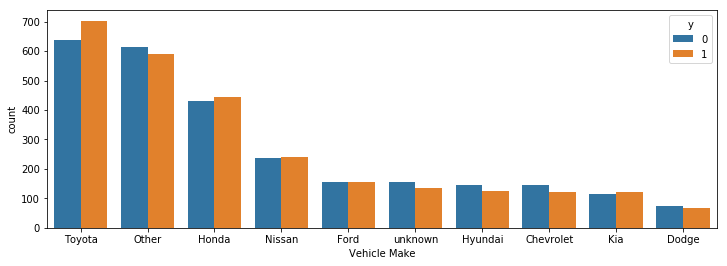

In [200]:
# Explore the vehicle make
dat_model['vehicle_make'].drop_duplicates().count()
# There are too many vehicle makes (48). Select top 9 and bucket the rest in "other"
top_9 = pd.value_counts(dat_model['vehicle_make']).iloc[:9].index
dat_model['vehicle_make'] = np.where(dat_model['vehicle_make'].isin(top_9) == False, 'Other', dat_model['vehicle_make'])

# Plot top 10 vehicle makes by response
plt.rcParams['figure.figsize'] = [12,4]
ax = sns.countplot(x='vehicle_make', hue='y', data=dat_model, order=pd.value_counts(dat_model['vehicle_make']).index)
ax.set(xlabel='Vehicle Make')

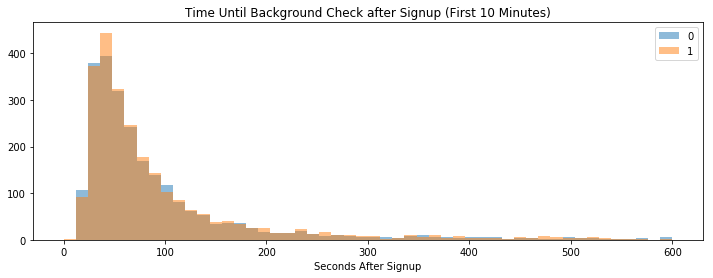

In [201]:
# Explore times between signup and bgc
dat_model['time_to_bgc'] = (dat_model['bgc_date'] - dat_model['signup_timestamp']).dt.seconds

plt.hist(dat_model['time_to_bgc'].loc[dat_model['y'] == 0], label='0', bins=50, alpha=0.5, range=[0,600])
plt.hist(dat_model['time_to_bgc'].loc[dat_model['y'] == 1], label='1', bins=50, alpha=0.5, range=[0,600])
plt.xlabel('Seconds After Signup')
plt.title('Time Until Background Check after Signup (First 10 Minutes)')
plt.legend()
plt.show()

In [202]:
round(dat_model.groupby(dat_model['y']).describe()['time_to_bgc'], 2)
# The first 10 minutes looks similar, but the mean values are very different

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,2704.0,3549.06,14087.02,13.0,40.0,67.0,136.25,86355.0
1,2704.0,2124.48,10594.57,11.0,40.0,65.0,127.00,85881.0


[Text(0.5,0,'Signup OS')]

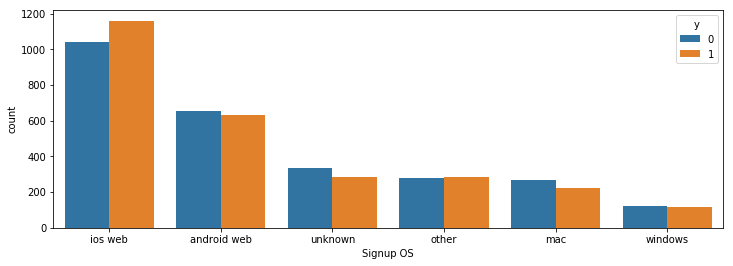

In [203]:
# Explore the signup os
ax = sns.countplot(x='signup_os', hue='y', data=dat_model, order=pd.value_counts(dat_model['signup_os']).index)
ax.set(xlabel='Signup OS')
# There are some differences here that may help predict

[Text(0.5,0,'Signup Channel')]

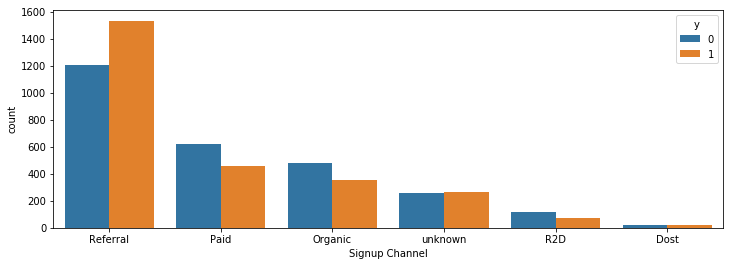

In [204]:
# Explore the signup os
ax = sns.countplot(x='signup_channel', hue='y', data=dat_model, order=pd.value_counts(dat_model['signup_channel']).index)
ax.set(xlabel='Signup Channel')
# There are some differences here that may help predict

[Text(0.5,0,'City Name')]

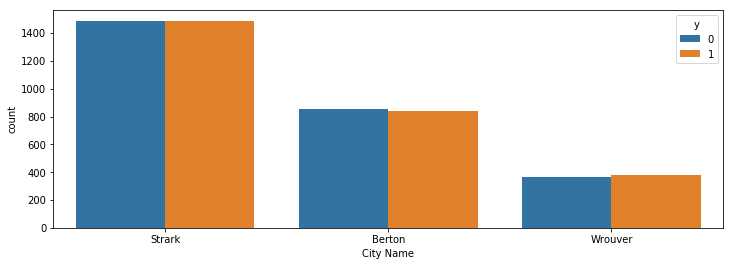

In [205]:
# Explore the signup os
ax = sns.countplot(x='city_name', hue='y', data=dat_model, order=pd.value_counts(dat_model['city_name']).index)
ax.set(xlabel='City Name')
# They are all equal, no predictive power

[Text(0.5,0,'Vehicle Year')]

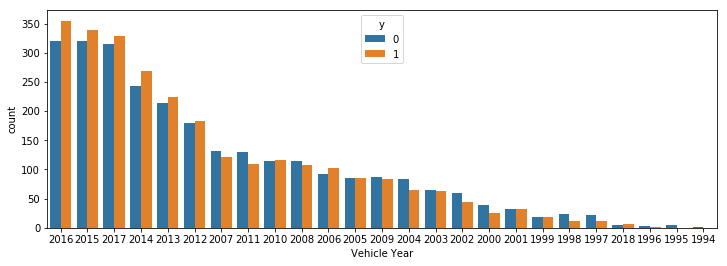

In [206]:
# Explore the signup os
ax = sns.countplot(x='vehicle_year', hue='y', data=dat_model, order=pd.value_counts(dat_model['vehicle_year']).index)
ax.set(xlabel='Vehicle Year')
# Newer cars appear more likely to complete first trip

# Modeling

In [212]:
# Select the variables to make into dummies
vars_for_dummies = ['signup_os', 'signup_channel', 'vehicle_make']

# Create dummy variables for categorical data
dummies = pd.get_dummies(dat_model[vars_for_dummies])

dat_model_dummies = pd.concat([dat_model, dummies], axis=1)

# Drop columns not used in modeling
y = dat_model_dummies['y']

vars_to_drop = ['index', 'id', 'city_name', 'signup_timestamp', 
                'bgc_date', 'vehicle_added_date', 'signup_os', 
                'signup_channel', 'vehicle_make', 'vehicle_model', 
                'first_completed_trip_timestamp', 'time_to_first_trip', 
                'time_since_signup', 'y']

dat_model_dummies = dat_model_dummies.drop(vars_to_drop, axis=1)

# Create train and test set data
x_train, x_test, y_train, y_test = train_test_split(dat_model_dummies, y, test_size=0.25, random_state=0)

# Fit the logistic regression model
logisticRegr = sm.Logit(y_train, x_train)

predictions = logisticRegr.fit()

# Print the model performance
print(predictions.summary2())

Optimization terminated successfully.
         Current function value: 0.679427
         Iterations 5
                                    Results: Logit
Model:                      Logit                   No. Iterations:          5.0000   
Dependent Variable:         y                       Pseudo R-squared:        0.020    
Date:                       2018-12-09 14:32        AIC:                     5555.5112
No. Observations:           4056                    BIC:                     5694.2861
Df Model:                   21                      Log-Likelihood:          -2755.8  
Df Residuals:               4034                    LL-Null:                 -2811.3  
Converged:                  1.0000                  Scale:                   1.0000   
--------------------------------------------------------------------------------------
                         Coef.     Std.Err.     z    P>|z|      [0.025       0.975]   
----------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [213]:
round(np.exp(predictions.params), 4)

vehicle_year               1.0189
time_to_bgc                1.0000
signup_os_android web      0.0000
signup_os_ios web          0.0000
signup_os_mac              0.0000
signup_os_other            0.0000
signup_os_unknown          0.0000
signup_os_windows          0.0000
signup_channel_Dost        0.0000
signup_channel_Organic     0.0000
signup_channel_Paid        0.0000
signup_channel_R2D         0.0000
signup_channel_Referral    0.0000
signup_channel_unknown     0.0000
vehicle_make_Chevrolet     0.0001
vehicle_make_Dodge         0.0002
vehicle_make_Ford          0.0002
vehicle_make_Honda         0.0002
vehicle_make_Hyundai       0.0001
vehicle_make_Kia           0.0002
vehicle_make_Nissan        0.0002
vehicle_make_Other         0.0002
vehicle_make_Toyota        0.0002
vehicle_make_unknown       0.0002
dtype: float64

In [214]:
# Generate a logistic regression model using sklearn
logisticRegr_2 = LogisticRegression()

logisticRegr_2.fit(x_train, y_train)

predictions_2 = logisticRegr_2.predict(x_test)

In [215]:
logisticRegr_2.coef_
# Coefficients are very small

array([[-3.67221771e-05, -8.34969419e-06,  1.66121143e-02,
         7.19260519e-02, -4.39085577e-02, -5.75899123e-03,
        -3.58938465e-02, -3.52908880e-03, -3.95257237e-03,
        -8.87169980e-02, -1.29591454e-01, -3.33131124e-02,
         2.44907233e-01,  1.01145856e-02, -2.02380103e-02,
        -6.38133566e-03,  1.05113063e-02, -2.58304778e-03,
        -8.58442961e-03,  3.99520934e-03,  6.24228728e-03,
        -3.26992302e-02,  5.07484759e-02, -1.56354335e-03]])

Text(0.5,257.44,'Predicted label')

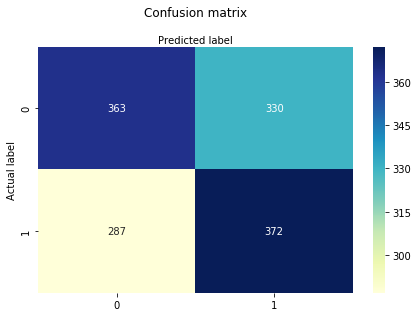

In [222]:
# Calculate confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, predictions_2)


# Plot confusion matrix
plt.rcParams['figure.figsize'] = [6,4]
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [219]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions_2))
print("Precision:",metrics.precision_score(y_test, predictions_2))
print("Recall:",metrics.recall_score(y_test, predictions_2))

Accuracy: 0.5436390532544378
Precision: 0.5299145299145299
Recall: 0.5644916540212443


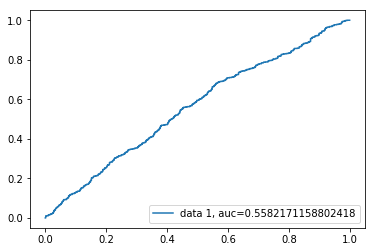

In [223]:
#Plot the ROC curve
y_pred_proba = logisticRegr_2.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()